# Using pre-trained network for bone age problem
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. We will be using a pretrained network.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [3]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/rsna-bone-age/mode951.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode982.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model007.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/model046.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode_tmp.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model025.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-550'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model004.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model003.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode1045.pth'),
 Posi

In [4]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


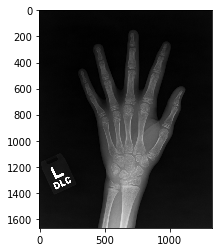

In [5]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [6]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [6]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [7]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They used 500x500 images.

In [8]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

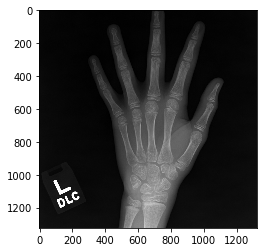

In [9]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

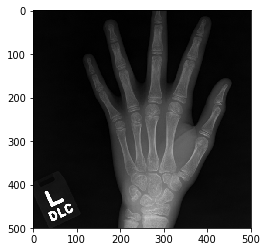

In [10]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (550, 550))
im = random_crop(im, 500, 500)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

-3.189072892336604


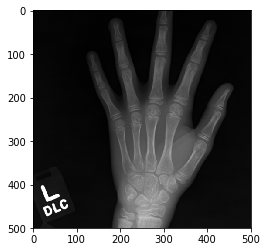

In [11]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

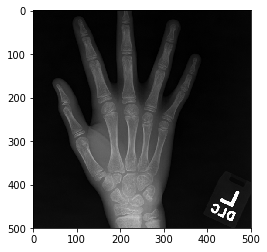

In [12]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [13]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

In [14]:
a = train.head()

In [15]:
row = a.iloc[0]
b = (1 if row["male"] == True else 0)
b

1

In [17]:
b = int(row["male"] == True)
b

1

## Dataset

In [16]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True, sz=400):
        self.path_to_images = PATH/"boneage-550/"
        self.transforms = transforms
        self.df = df
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x2 = int(row["male"] == True)
        x = cv2.imread(str(path)).astype(np.float32)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        return (np.rollaxis(x, 2), x2), y

In [17]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [18]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [19]:
# run this multiple times to get different images
x, y = train_ds[10]
x1, x2 = x
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [20]:
x1.shape,x2,y

((3, 400, 400), 1, 216)

## Model

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.out = 512 + 32
        self.bn0 = nn.BatchNorm1d(32)
        self.bn1 = nn.BatchNorm1d(self.out)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc0 = nn.Linear(1, 32)
        self.fc1 = nn.Linear(self.out, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        img, x2 = x
        img = F.relu(self.top_model(img))
        img2 = nn.AdaptiveAvgPool2d((1,1))(img)
        img2 = img2.view(img2.shape[0], -1)
        x2 = self.fc0(x2.unsqueeze(1)).float()
        x2 = self.bn0(F.relu(x2)) 
        x = torch.cat([img2, x2], 1)
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [27]:
model = Net().cuda()

In [28]:
x,y = next(iter(train_dl))
x1, x2 = x

In [29]:
x1 = x1.cuda().float()
x2 = x2.cuda().float()
y =  y.cuda().float()

In [30]:
x1.shape, x2.unsqueeze(1).shape

(torch.Size([16, 3, 400, 400]), torch.Size([16, 1]))

In [31]:
y_hat = model((x1, x2))

In [32]:
# F.l1_loss note that this is a regression problem
F.l1_loss(y_hat, y.unsqueeze(1)).item()

130.5974578857422

## Learning rate finder

In [43]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[ind])
            x1, x2 = x
            x1 = x1.cuda().float()
            x2 = x2.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model((x1, x2))
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [44]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

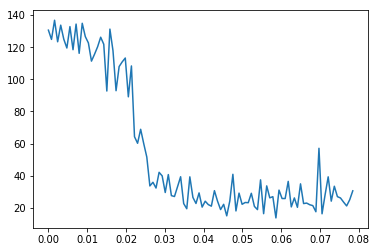

In [45]:
plt.plot(lrs[:100], losses[:100])
plt.show()

## Triangular learning rate training

In [46]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [74]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.04, epochs = 4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x1, x2 = x
            x1 = x1.cuda().float()
            x2 = x2.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model((x1, x2))
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_loss(model, valid_dl)
    return sum_loss/total

In [85]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = x1.cuda().float()
        x2 = x2.cuda().float()
        y = y.cuda().float().unsqueeze(1)
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f" % (sum_loss/total))

## Training with triangular rates

In [76]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.035, epochs=4):
    start = datetime.now() 
    loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
    end = datetime.now()
    t = 'Time elapsed {}'.format(end - start)
    print("----End of step", t)

In [77]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [78]:
model = Net().cuda()

In [79]:
training_loop(model, train_dl, valid_dl, epochs=8)

train loss 60.311
val loss 17.226


/home/yinterian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


train loss 17.297
val loss 16.821
train loss 17.938
val loss 15.322
train loss 16.665
val loss 15.128
train loss 15.013
val loss 13.933
train loss 13.803
val loss 13.847
train loss 13.456
val loss 13.536
train loss 13.379
val loss 13.912
----End of step Time elapsed 0:29:32.354381


In [80]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model-13-epochs-8.pth"
save_model(model, p)

In [81]:
model.load_state_dict(torch.load(p))

In [82]:
val_loss(model, valid_dl)

val loss 13.912


/home/yinterian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


tensor(13.4515, device='cuda:0')

In [83]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [84]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [87]:
unfreeze(model, 7)
unfreeze(model, 6)
unfreeze(model, 5)
unfreeze(model, 4)

In [86]:
training_loop(model, train_dl, valid_dl, lr_low=1e-6, lr_high=0.001, epochs=4)

train loss 13.233
val loss 13.706
train loss 13.237
val loss 13.670
train loss 13.249
val loss 13.791
train loss 13.137
val loss 13.624
----End of step Time elapsed 0:14:43.436034


In [ ]:
training_loop(model, train_dl, valid_dl, lr_low=1e-6, lr_high=0.0001, epochs=4)

# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb